# Urban Climate Risk Predictor - Model Training

This notebook demonstrates how to train a machine learning model to predict urban climate risks based on various features.

In [1]:
# Ensure required libraries are installed
%pip install matplotlib seaborn scikit-learn

# Import libraries
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import os

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 1. Load and Prepare Data

In a real project, we would load actual climate data. For this demonstration, we'll create synthetic data.

In [2]:
# Generate synthetic data
np.random.seed(42)
n_samples = 1000

# Features
population = np.random.randint(50000, 5000000, n_samples)
temperature_increase = np.random.uniform(0.5, 4.0, n_samples)
urban_density = np.random.randint(0, 3, n_samples)  # 0: low, 1: medium, 2: high
infrastructure_age = np.random.randint(0, 3, n_samples)  # 0: new, 1: moderate, 2: aging

# Create DataFrame
data = pd.DataFrame({
    'population': population,
    'temperature_increase': temperature_increase,
    'urban_density': urban_density,
    'infrastructure_age': infrastructure_age
})

In [3]:
# Generate target variable (risk level) based on features
# This simulates a relationship between features and risk

def calculate_risk_score(row):
    score = 0
    
    # Population factor
    score += row['population'] / 5000000 * 25  # Up to 25 points
    
    # Temperature factor
    score += row['temperature_increase'] / 4.0 * 35  # Up to 35 points
    
    # Urban density factor
    score += row['urban_density'] * 15  # Up to 30 points
    
    # Infrastructure factor
    score += row['infrastructure_age'] * 15  # Up to 30 points
    
    # Add some noise
    score += np.random.normal(0, 5)
    
    return min(100, max(0, score))

data['risk_score'] = data.apply(calculate_risk_score, axis=1)
data['risk_level'] = pd.cut(
    data['risk_score'], 
    bins=[0, 40, 70, 100], 
    labels=['low', 'medium', 'high']
)

## 2. Data Exploration and Visualization

In [4]:
# Display basic statistics
data.describe()

,population,temperature_increase,urban_density,infrastructure_age,risk_score
count,1.000000e+03,1000.000000,1000.00000,1000.000000,1000.000000
mean,2.535232e+06,2.261238,0.99600,0.979000,61.867940
std,1.409882e+06,0.998239,0.82381,0.822944,21.430207
min,5.040400e+04,0.500831,0.00000,0.000000,1.977324
25%,1.348713e+06,1.393854,0.00000,0.000000,47.106014
50%,2.556260e+06,2.302205,1.00000,1.000000,63.470208
75%,3.735511e+06,3.124924,2.00000,2.000000,77.312449
max,4.999499e+06,3.997737,2.00000,2.000000,100.000000


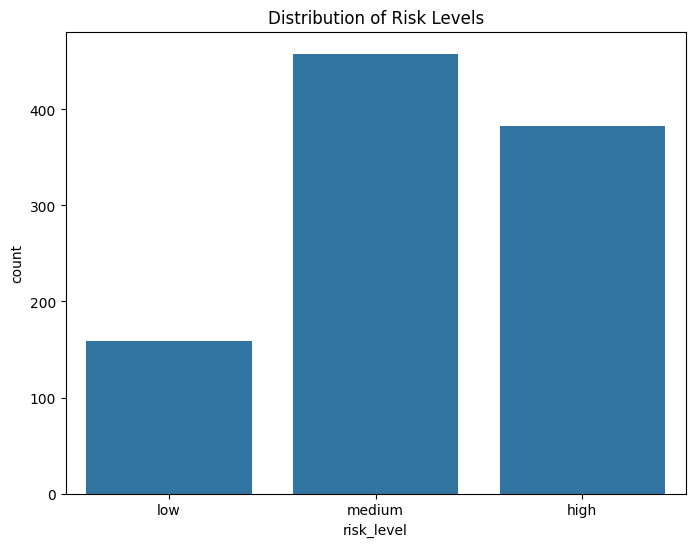

In [5]:
# Check class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='risk_level', data=data)
plt.title('Distribution of Risk Levels')
plt.show()

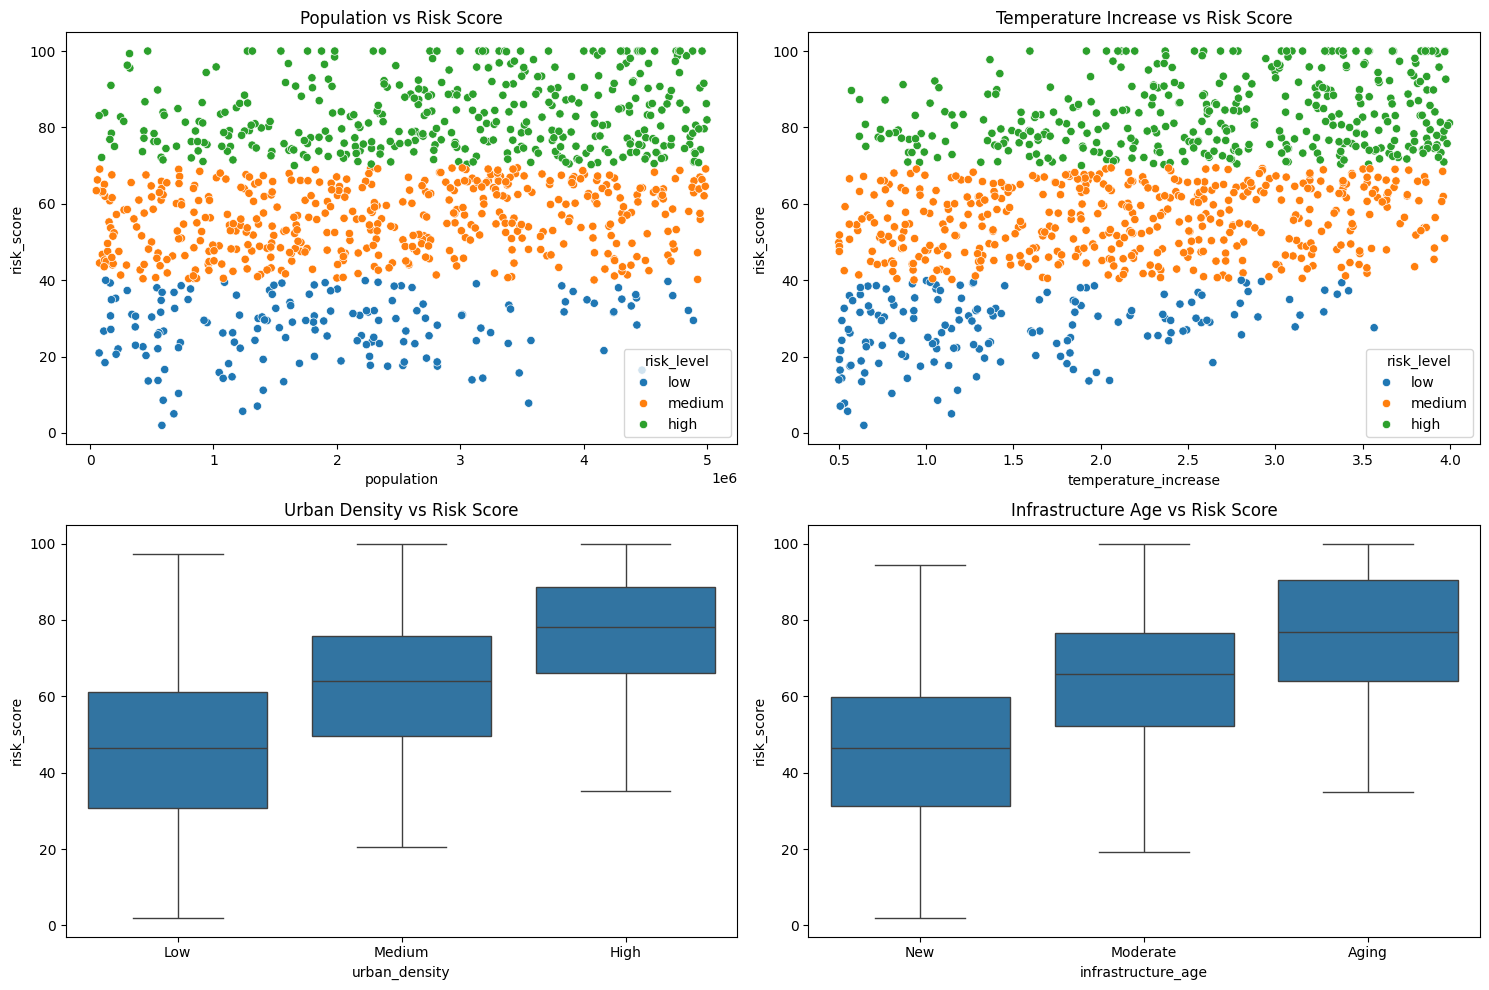

In [6]:
# Visualize relationship between features and risk score
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x='population', y='risk_score', hue='risk_level', data=data)
plt.title('Population vs Risk Score')

plt.subplot(2, 2, 2)
sns.scatterplot(x='temperature_increase', y='risk_score', hue='risk_level', data=data)
plt.title('Temperature Increase vs Risk Score')

plt.subplot(2, 2, 3)
sns.boxplot(x='urban_density', y='risk_score', data=data)
plt.title('Urban Density vs Risk Score')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])

plt.subplot(2, 2, 4)
sns.boxplot(x='infrastructure_age', y='risk_score', data=data)
plt.title('Infrastructure Age vs Risk Score')
plt.xticks([0, 1, 2], ['New', 'Moderate', 'Aging'])

plt.tight_layout()
plt.show()

## 3. Prepare Data for Training

In [7]:
# Convert risk level to binary (high risk or not)
data['high_risk'] = (data['risk_level'] == 'high').astype(int)

# Features and target
X = data[['population', 'temperature_increase', 'urban_density', 'infrastructure_age']]
y = data['high_risk']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Train the Model

In [8]:
# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       122
           1       0.89      0.90      0.89        78

    accuracy                           0.92       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.92      0.92      0.92       200



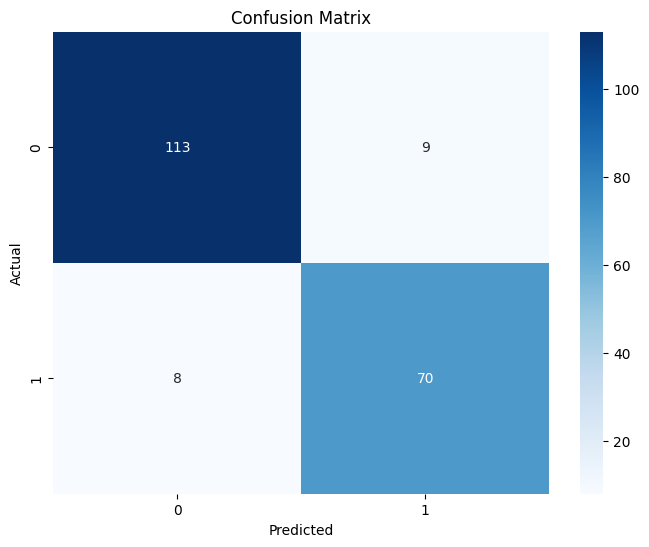

In [9]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 5. Feature Importance

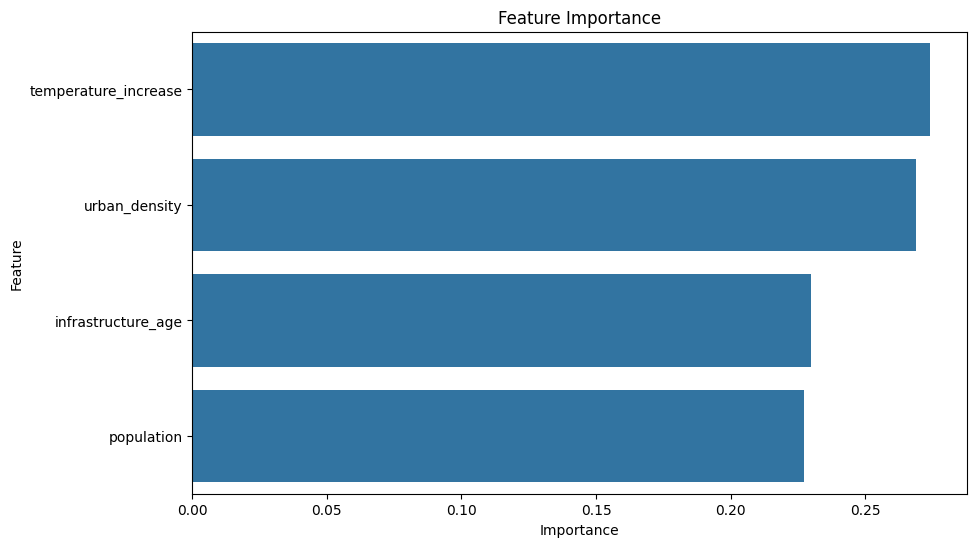

In [10]:
# Check feature importance
importances = model.feature_importances_
feature_names = X.columns

# Create DataFrame for easier visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

## 6. Save the Model

In [11]:
# Create directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the model
with open('../models/climate_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved successfully!")

Model saved successfully!


## 7. Test Prediction

In [12]:
# Test the model with a sample input
sample_input = np.array([[800000, 2.5, 2, 1]])  # Population, temp increase, high density, moderate infrastructure
sample_scaled = scaler.transform(sample_input)

# Predict probability of high risk
risk_prob = model.predict_proba(sample_scaled)[0][1]
risk_score = risk_prob * 100

print(f"Risk score: {risk_score:.1f}%")
if risk_score > 70:
    print("Risk level: High")
elif risk_score > 40:
    print("Risk level: Medium")
else:
    print("Risk level: Low")

Risk score: 98.0%
Risk level: High


C:\Users\patil\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
